# Investing in real estate vs an index fund

This notbeook quantitatively compares two investment strategies: real estate purchase and index fund investing. We will use the S&P500 index specifically. Many mutual funds and exchange-traded funds track this index and are readily available for any person to buy shares. For example, anyone can buy shares of Schwab S&P 500 Index Fund (SWPPX) or Vanguard S&P 500 ETF (VOO) (or other examples) and that makes them effectively invested in all 500 of the most successful US companies. There is also an index for the total stock market, the Dow Jones US total market index, and it turns out that this index is extremely correlated with the S&P500 index, so our results will generalize to investment strategies based on the Dow Jones total market index.


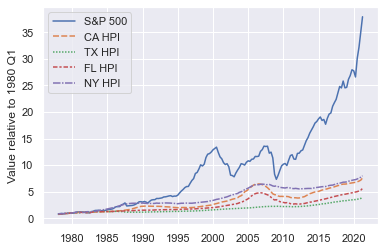

In [1]:
import numpy as np
import pandas as pd
from os import listdir
from datetime import timedelta
from datetime import datetime, date
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="ticks")

#create a dataFrame from each file
mortgage_rates=pd.read_csv("MORTGAGE30US.csv",index_col=0)
mortgage_rates.index=pd.to_datetime(mortgage_rates.index)
US_median_price=pd.read_csv("US_median_home_price.csv",index_col=0)
US_median_price.index=pd.to_datetime(US_median_price.index)

#csv file has 5 columns. we only need the Open price
SP500_df=pd.read_csv('HistoricalPrices.csv',index_col=0,usecols=[0,1])
SP500_df.index=pd.to_datetime(SP500_df.index)
#sort chronologically, every business day is included
SP500_df.sort_index(inplace=True) 

#take average of each quarter to compare with the housing price index
SP500_q=SP500_df.resample('QS').mean()
#normalize to 1980 Q1, same as house price index
SP500_q=SP500_q/SP500_q[SP500_q.index==datetime(1980,1,1)].values

#load the csv files of the states
files=listdir("states/")
frames=[]
for f in files:
    #load the csv into a DataFrame
    frames.append(pd.read_csv('states/'+f,index_col=0))
#combine all frames into a single frame. 1980 Q1 is set to 1
states_HPI=frames[0].join(frames[1:])/100
#dates are the first day of each quarter
states_HPI.index=pd.to_datetime(states_HPI.index)

#create a new frame with all data as columns
df=SP500_q.join(states_HPI,how='inner')
df.rename(columns={' Open': 'S&P 500',
                   'NYSTHPI': 'NY HPI',
                  'TXSTHPI': 'TX HPI',
                  'CASTHPI': 'CA HPI',
                  'FLSTHPI': 'FL HPI'},inplace=True)
sns.set()
#let's look at the 4 largest states in population
sns.lineplot(data=df[['S&P 500','CA HPI','TX HPI','FL HPI','NY HPI']])
plt.ylabel('Value relative to 1980 Q1')
plt.show()

## Trends we can see from the line plot
- Compared to the house price indices, the stock market index, S&P 500, has experienced the greatest growth and also the largest downturns such as the early 2000s and 2008-2009. In other words, there is greater risk in the stock market, but over periods of 30 years or longer, the stock market tends to increase. 
- Generally, the house prices for California, Texas, Florida, and New York have tended to increase over the last 40 years, but their growth is quite small compared to the S&P 500. 
- California, Florida, and New York house prices dipped in 2008 just like the stock market. Of these housing markets, Texas is the only one that was insulated from the recession. We can use our data set to determine which other states were unaffected by the 2008 recession as well as by other down turns in the past. Texas and those other states would be a way to mitigate risk.

## How to compare RE and index investing
To make a valid comparison between these two strategies we will need to make the real estate scenario more concrete. Suppose we would want the following: 
- downpayment of 20% of the home value 
- we have \\$ 10k available for the downpayment 
- That means we would be looking for a house of \\$ 50k. For now, let's assume that in 1990, a good home could be found at this price in any state.

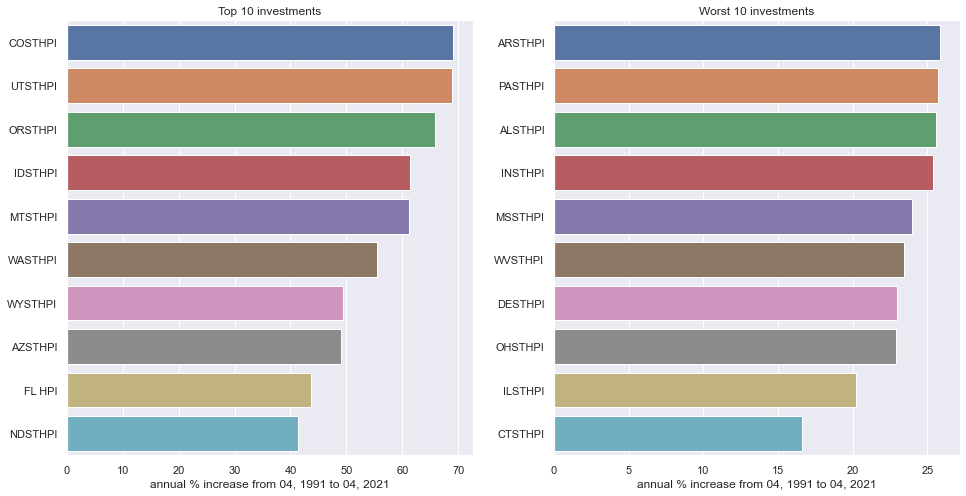

In [2]:

def calc_changes(df,start_date,final_date):
    """ Calculate the % change of each of the categories in a DataFrame
    INPUTS
    df: pandas dataframe with a datetime index
    start_time: datetime object
    final_date: datetime object
    OUTPUT
    changes: values are the yearly average
    """
    ind=df.index>=start_date
    #select the closest values to the start date
    start_val=df[ind].iloc[0]
    stop_val=df[df.index>=final_date].iloc[0]
    #how much would the investment grow in each column?
    changes=(stop_val-start_val)/start_val
    n_years=final_date.year-start_date.year +(final_date.month-start_date.month)/12
    #convert DataFrame to a Series and change to percentage
    changes=changes.squeeze(axis=0)*100/n_years 
    changes.sort_values(inplace=True,ascending=False)
    #determine the average interest rate on a fixed, 30-year loan at the purchase time
    int_rate=mortgage_rates['MORTGAGE30US'][mortgage_rates.index>=start_date]
    #real estate gains are relative to the downpayment, instead of the house value
    changes[1:]=changes[1:]*5-int_rate[0]/100 #substract the mortgage rate
    changes.sort_values(inplace=True,ascending=False)
    return changes

#choose a start date
start_date=datetime(1991,4,1)
#choose the last date that's available
final_date=df.index[-1]
example1=calc_changes(df,start_date,final_date)
#show these changes in a bar plot
def plot_best_and_worst(for_plot,start_date,final_date,use_xlim=False):
    fig, ax=plt.subplots(1,2,figsize=(16,8))
    for_xaxis='annual % increase from '+start_date.strftime('%m, %Y')+' to '+final_date.strftime('%m, %Y')
    #only show the top 10
    sns.barplot(x=for_plot[:10],y=for_plot[:10].index,ax=ax[0],orient='h')
    ax[0].set_title('Top 10 investments')
    ax[0].set_xlabel(for_xaxis)
    if use_xlim:
        ax[0].set_xlim(0,40)
    #for_plot=example1[-10:]
    sns.barplot(x=for_plot[-10:],y=for_plot[-10:].index,ax=ax[1],orient='h')
    ax[1].set_title('Worst 10 investments')
    ax[1].set_xlabel(for_xaxis)
    if use_xlim:
        ax[1].set_xlim(0,40)
    plt.show()
    
#determine the average interest rate on a fixed, 30-year loan at the purchase time
#int_rate=mortgage_rates['MORTGAGE30US'][mortgage_rates.index>=start_date]
#example1[1:]=example1[1:]*5-int_rate[0]/100
#example1.sort_values(inplace=True,ascending=False)
plot_best_and_worst(example1,start_date,final_date,False)

## Homes in Colorado, Utah, and Oregon were the best investment decisions for 1991 to 2021
__Main results__: The period from 1991 to 2021, the S&P 500 is not one of the top 10. Nonetheless, the index fund is not in the worst 10 either. The best housing markets were Colorado, Utah, and Oregon. However, this comparison is unfair because the scenarios with a home purchase all assume the full repayment of the mortgage, whereas the nest egg in the index fund grew without any additional payments and without dividends reinvested. With the payments and dividends, the index fund would have show a greater return on investment.

_Note_: The real estate gains are relative to the downpayment, instead of the house value, and we have subtracted the mortgage rate. 

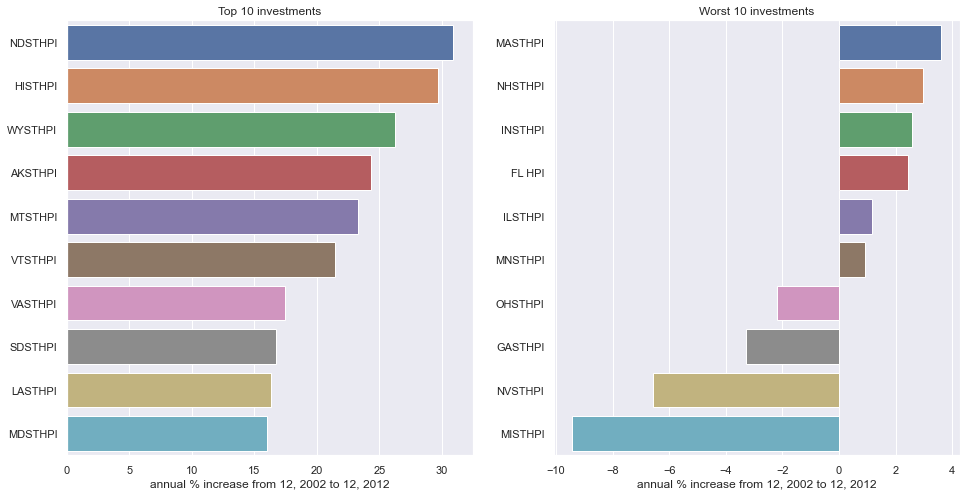

In [3]:
final_date=datetime(2012,12,1)
start_date=datetime(2002,12,1)
example2=calc_changes(df,start_date,final_date)
plot_best_and_worst(example2,start_date,final_date)

## Homes in North Dakota, Hawaii, and Wyoming were the best investment decisions for 2002 to 2012
__Main results__: All investment gains depend on the date of buying and date of selling. We can see that the results for this period of 2002 to 2012 show different states as the top housing markets compared to the time period assesed above. Again, the index fund is not one of the best or worst investments. On the right, we can see 4 states that have negative return on investments. Terrible time to sell an asset in those states.

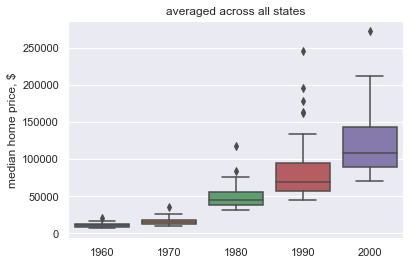

In [8]:
median_home=pd.read_csv("https://www2.census.gov/programs-surveys/decennial/tables/time-series/coh-values/values-unadj.txt",
                        header=None,skiprows=4,skipfooter=3,engine='python',sep='$',usecols=range(6))
median_home.columns=['state','2000','1990','1980','1970','1960']
#re-order the columns
median_home=median_home.reindex(columns=['state','1960','1970','1980','1990','2000'])
for col in median_home.columns[1:]:
    #remove commas and convert to numbers
    median_home[col]=pd.to_numeric(median_home[col].str.replace(",",""))
#first row is for United states and we will drop it during the merge
median_home['for_merge']=np.arange(len(median_home))-1
#add columns of abbreviations and state names that don't have space fillers
frame=pd.read_csv('state_abbrev.csv')
median_home=pd.merge(frame,median_home,left_index=True,right_on='for_merge')
median_home.drop(['state','for_merge'],axis='columns',inplace=True)
#median_home.describe()

sns.boxplot(data=median_home)
plt.ylabel('median home price, $')
plt.title('averaged across all states')
plt.show()

In [6]:
#initial investment
principal=10000 #$10k

def calc_mortgage(mortgage_rates,start_date,downpayment,final_date):
    """ Calculates the total cost of a mortgage
    Assumes that the mortage is for 30 years at a fixed interest rate.
    INPUT
    mortgage_rates: DataFrame of interest rates which are not fractional, but are percentages multiplied by 100
    start_date: datetime object
    downpayment: downpayment for home purchase
    """
    #determine the average interest rate on a fixed, 30-year loan at the purchase time
    int_rate=mortgage_rates['MORTGAGE30US'][mortgage_rates.index>=start_date]
    r=int_rate[0]/12/100 #monthly interest rate
    N_total=30*12 # number of monthly payments
    #assume the principal investment is 20% of the home price
    house_price=5*downpayment
    #calculate the initial value of the loan
    loan_principal=house_price-downpayment
    #calculate the monthly mortgage payment
    cost=loan_principal*r/(1-(1 + r)**(-N_total))
    #how many months have passed?
    N_elapsed=(final_date.year-start_date.year)*12 + final_date.month-start_date.month
    #calculate the total cost of the mortgage
    cost=cost*np.array([N_total, N_elapsed])
    return cost, house_price

cost, house_price=calc_mortgage(mortgage_rates,start_date,principal,final_date)

